# Brain Tumor Detection Using CNN and VGG16

In this notebook, I am using a brain tumor MRI dataset from Kaggle.  
The goal is to classify MRI images into **4 classes**:

- glioma  
- meningioma  
- pituitary  
- no_tumor  

I will train two models:
1. A simple Convolutional Neural Network (CNN)  
2. VGG16 (Transfer Learning)



In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import os


In [6]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dir = "Training"
test_dir = "Testing"

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

classes = train_dataset.classes
print("Classes:", classes)


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


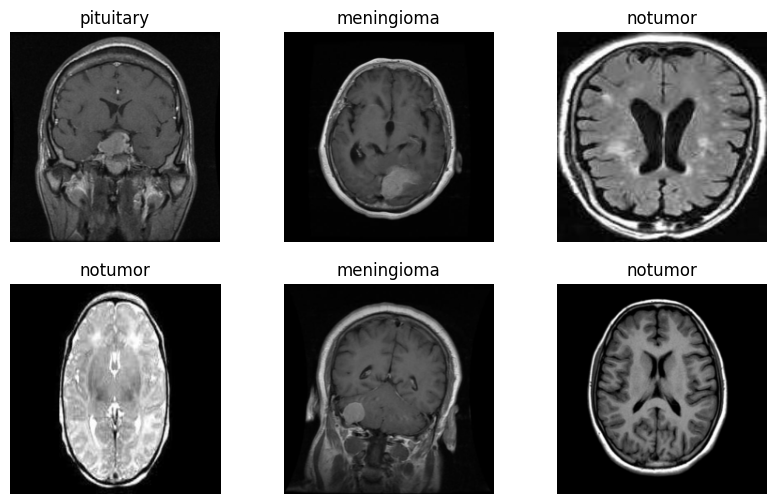

In [7]:
import random

def show_random_images(dataset):
    fig = plt.figure(figsize=(10,6))
    
    for i in range(6):
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]
        img = img.permute(1,2,0)

        ax = fig.add_subplot(2, 3, i+1)
        ax.imshow(img)
        ax.set_title(classes[label])
        ax.axis("off")

show_random_images(train_dataset)


In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = SimpleCNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)


In [10]:
num_epochs = 5

for epoch in range(num_epochs):
    cnn_model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


Epoch 1/5, Loss: 0.0608, Accuracy: 0.9793
Epoch 2/5, Loss: 0.0368, Accuracy: 0.9879
Epoch 3/5, Loss: 0.0338, Accuracy: 0.9876
Epoch 4/5, Loss: 0.0312, Accuracy: 0.9895
Epoch 5/5, Loss: 0.0146, Accuracy: 0.9967


In [9]:
vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

for param in vgg.features.parameters():
    param.requires_grad = False

vgg.classifier[6] = nn.Linear(4096, 4)

vgg = vgg.to(device)
vgg_optimizer = optim.Adam(vgg.parameters(), lr=0.0001)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\sajid/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [07:33<00:00, 1.22MB/s] 


In [10]:
num_epochs = 5

for epoch in range(num_epochs):
    vgg.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        vgg_optimizer.zero_grad()
        outputs = vgg(images)

        loss = loss_fn(outputs, labels)
        loss.backward()
        vgg_optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")




Epoch 1/5, Loss: 0.3761, Accuracy: 0.8550
Epoch 2/5, Loss: 0.1776, Accuracy: 0.9377
Epoch 3/5, Loss: 0.1024, Accuracy: 0.9639
Epoch 4/5, Loss: 0.0581, Accuracy: 0.9774
Epoch 5/5, Loss: 0.0543, Accuracy: 0.9800


Simple CNN Accuracy: 0.9967
VGG16 Accuracy: 0.98


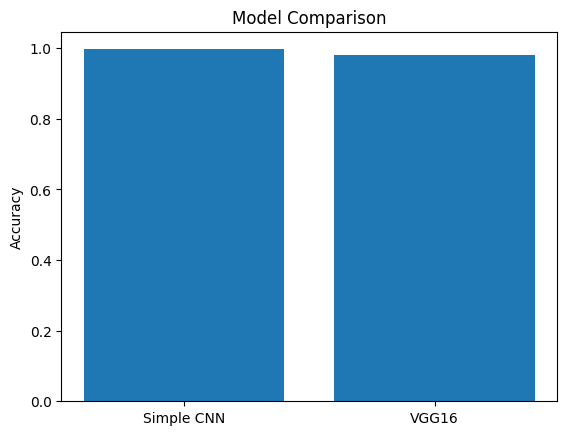

In [12]:

cnn_acc = 0.9967  
vgg_acc = 0.9800   

print("Simple CNN Accuracy:", cnn_acc)
print("VGG16 Accuracy:", vgg_acc)

labels = ["Simple CNN", "VGG16"]
accuracies = [cnn_acc, vgg_acc]

plt.bar(labels, accuracies)
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.show()


In [11]:
torch.save(cnn_model.state_dict(), "best_model.pth")
print("Saved Simple CNN as best model.")


Saved Simple CNN as best model.
